#Monetmaker

@author: Leonardo Perugini, University of Bologna

<br/>

Project inspired by the paper "<a href="https://arxiv.org/pdf/1508.06576.pdf">A Neural Algorithm of Artistic style</a>" by L.A. Gatys, A.S. Ecker, M. Bethge (2015).

##Introduction
####This application is built to transfer the artistic style of an image (e.g. a famous painting) on the content of a second picture:

> <h3> <img src="https://drive.google.com/uc?export=view&id=1GsBgdu2_ee5SUXlG4SJCyfd06oEZUOl_" width ="500" align="center"> Basilica of San Petronio, Bologna (Italy)</h3>



> <h3> <img src="https://drive.google.com/uc?export=view&id=1-mQBo1h0C2UJRlP9abM86gl2aFT9Sdo-" width ="500" align="center"> Starry Night by Van Gogh</h3>

<br/><br/><br/>

---

<br/><br/>
####The result is obtained by adjusting the image in order to jointly minimize two loss functions (style loss and content loss), using the content image as the initial base:

> <h3> <img src="https://drive.google.com/uc?export=view&id=1eMlP5COO-43ghsVNjR8_vuo6zFWNs-dd" width ="500" align="center"> Maybe, if Van Gogh was from Bologna...</h3>

The initial image has been modified 2000 times (steps) to obtain this result.
The code is presented below.

---


Before starting, save a copy of this notebook in your Google Drive. Open it, go to `Edit > Notebook Settings` and choose GPU under `Hardware acceleration`.

Then, click on the folder icon (Files) on the left of the screen and click on "Mount Drive". This allows this program to load images from the folders inside `drive/My Drive/Colab Notebooks/imgs` (if they are not present, they are created by the next code cell).

In [0]:
import tensorflow as tf
from keras.applications.vgg19 import VGG19, preprocess_input
from keras.preprocessing.image import img_to_array
from keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import sys
import time
from pathlib import Path
from urllib import request

imgs_folder = "drive/My Drive/Colab Notebooks/imgs"
log_folder = "drive/My Drive/Colab Notebooks/Log/from_content/"
Path(imgs_folder+"/content").mkdir(parents=True, exist_ok=True)
Path(imgs_folder+"/style").mkdir(parents=True, exist_ok=True)
Path(imgs_folder+"/generated/transfer/from_content/").mkdir(parents=True, exist_ok=True)
Path(log_folder).mkdir(parents=True, exist_ok=True)

if not Path(imgs_folder+"/content/san_luca.jpg").exists():
    request.urlretrieve("https://www.arcobalenoinviaggio.it/wp-content/uploads/2018/07/SAM_1328_small.jpg",
                        imgs_folder+"/content/san_luca.jpg")
    
if not Path(imgs_folder+"/style/starry_night.jpeg").exists():
    request.urlretrieve("https://i.ebayimg.com/00/s/MTI3OVgxNTk5/z/L44AAOSwesVbRExS/$_3.JPG",
                        imgs_folder+"/style/starry_night.jpg")


##Utils
Some utility functions needed by the application.

In [0]:
def load_img(path, max_dim=512):
    """
    Used to load an image, described by its path, as a Tensor with values between 0 and 1.
    The image is reshaped to make its longest dimension become equal to max_dim (by default 512)
    """
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3)  # tf.Tensor, shape: (x, y, 3), int values in [0, 255]
    img = tf.image.convert_image_dtype(img, tf.float32) # tf.Tensor, shape: (x, y, 3), float values in [0, 1]
    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    longest_dim = max(shape)
    scale = max_dim / longest_dim
    new_shape = tf.cast(shape * scale, tf.int32)
    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]    # shape (1, x, y, 3)
    return img


def get_layers_by_name(model, layer_names):
    """
    Used to obtain the list of the layers in the specified model, starting from their names
    """
    return [model.get_layer(l) for l in layer_names]


def get_outputs_by_layer_names(model, layer_names):
    """
    This returns the output features of the specified model layers
    """
    result = [model.get_layer(l).output for l in layer_names]
    return result


def get_intermediate_layers_model(layer_names):
    """
    Used to build a model based on the input and outputs of the specified layers, 
    starting from a VGG19 model without the fully connected layers
    """
    vgg19 = tf.keras.applications.VGG19(include_top=False, weights='imagenet', pooling='avg')
    vgg19.trainable = False
    output_layers = get_outputs_by_layer_names(vgg19, layer_names)
    intermediate_layers_model = tf.keras.Model([vgg19.input], output_layers)
    return intermediate_layers_model


def clip_image_0_1(img):
    """
    Function to keep the (float) values of a processed image between 0 and 1
    """
    return tf.clip_by_value(img, clip_value_min=0.0, clip_value_max=1.0)

def show_feature_maps(model, image):
    """
    Function to show the feature maps in the layers of the passed model for the passed image
    """
    feature_maps = model.predict(image)
    # plot the output from each block
    square = 8
    for fmap in feature_maps:
        # plot all 64 maps in an 8x8 squares
        ix = 1
        for _ in range(square):
            for _ in range(square):
                # specify subplot and turn of axis
                ax = plt.subplot(square, square, ix)
                ax.set_xticks([])
                ax.set_yticks([])
                # plot filter channel in grayscale
                plt.imshow(fmap[:, :, ix-1], cmap='gray')
                ix += 1
        # show the figure
        plt.show()


###Logger
This class helps to perform the logging part of the applicaton.<br/>
It can write to a specified file the used parameters, their changes and the loss values at the end of an execution step.

In [0]:
class Logger:
    def __init__(self, log_folder, a, b, c, steps, content, style):
        now = time.localtime()
        #self.log_path = log_folder + "a{:.1f}_b{:.2f}_c{}_{}_steps.txt".format(a, b, c, steps)
        self.log_path = log_folder + style.split(".")[0] + "_" + content.split(".")[0] + "_" + time.strftime("%Y-%m-%d_%H-%M-%S.txt", now)
        self.logfile = open(self.log_path, "w")
        timestamp = time.strftime("%Y-%m-%d %H:%M:%S", now)
        self.logfile.write(timestamp + "\n")
        self.logfile.write("Weights (content, style, variation) = ({:.1f}, {:.2f}, {})\n".format(a, b, c))
        self.logfile.write("Update steps: {}\n".format(steps))
        self.logfile.write("Content image: " + content + "\n")
        self.logfile.write("Style   image: " + style + "\n\n")

    def param_change(self, step, a, b, c, lr):
        self.logfile.write("\n" + "-" * 40 + "\n")
        self.logfile.write("Parameters changed at step {}: ".format(step) +
                           "weights (content, style, variation) = ({:.1f}, {:.2f}, {}) ; ".format(a, b, c) +
                           "learning rate = " + str(lr) + "\n")

    def print_loss(self, step, loss, s_loss, c_loss):
        self.logfile.write("Step {:=5d} - total loss: {:=16.1f}\t[ S: {:=14.1f} ; C: {:=12.1f} ]\n".format(step, loss, s_loss, c_loss))
        self.logfile.flush()

    def close(self):
        ts = time.strftime("%H:%M:%S", time.localtime(1))
        self.logfile.write("\nFinished at " + ts + "\n")
        self.logfile.close()


##Content extraction
To reconstruct the content of the image, we use its feature representations in a chosen layer (here block4_conv2).
<br/>
It is also possible to visualize these features (see the later instructions).

In [0]:
class ContentExtractor(tf.keras.models.Model):
    """
    An instance of this class, when used to process an input image, 
    returns its content features extracted from the specified layer.
    In this application, the chosen layer is  "block4_conv2".
    """
    def __init__(self, content_layers):
        super(ContentExtractor, self).__init__()
        self.vgg = get_intermediate_layers_model(content_layers) # vgg is a Model(input, output)
        self.content_layers = content_layers
        self.vgg.trainable = False

    def __call__(self, inputs):
        # "inputs" is an image with float values between and 1
        inputs = inputs * 255
        preprocessed_input = preprocess_input(inputs)
        content_outputs = self.vgg(preprocessed_input)  # content features of the image
        content_dict = {self.content_layers[0]: content_outputs}
        return content_dict


The content loss functionis defined as the squared error between the feature representation of the processed image (content_outputs) and of the content image (content_target).
<br/>
Thus, being x the generated image, p the original content image, F and P their
respective feature representation and l the considered layer, the loss function is:

$$L_{content}(p, x, l) = w_c \sum_{i, j}(F^l_{ij}-P^l_{ij})^2$$

Since we use the content image itself as a base for the generated image, the value of this loss at the first iteration (step) will be 0.

In [0]:
def content_loss(content_outputs, content_targets, weight=0.5):
    """
    Loss function to compute the distance between the content representation of
    the processed image (content_outputs) and of the target style image (content_targets)
    """
    loss = weight * tf.add_n(
        [tf.reduce_mean((content_outputs[l] - content_targets[l])**2) for l in content_outputs.keys()])
    return loss


##Style extraction
As stated in the paper, it is possible to obtain a style representation of an image using the correlations between different convolutional filter responses.
<br/>
These correlations are given by the Gram matrix of the feature maps in each layer considered, divided by the number.
<br/>
The features are obtained as the output of the layers in the VGG19 model.

In [0]:
import keras.backend as K

def gram(x):
    """
    Return a gram matrix for the given input matrix.
    Args:
        x: the matrix to calculate the gram matrix of
    Returns:
        the gram matrix of x
    """
    shape = K.shape(x[0])
    # flatten the 3D tensor by converting each filter's 2D matrix of points
    # to a vector, thus we have the matrix: [filter_width x filter_height, num_filters]
    F = K.reshape(x, (shape[0] * shape[1], shape[2]))
    # take inner product over all the vectors to produce the Gram matrix
    product = K.dot(K.transpose(F), F)
    product /= tf.cast(shape[0]*shape[1], tf.float32)
    shape = K.shape([product])
    return K.reshape(product, shape)


class StyleExtractor(tf.keras.models.Model):
    """
    An instance of this class, when used to process an input image, returns
    its style features (Gram matrix) extracted from the specified layers.
    In this application, the chosen layers are: "block1_conv1", "block2_conv1",
    "block3_conv1", "block4_conv1", "block5_conv1".
    """
    def __init__(self, style_layers):
        super(StyleExtractor, self).__init__()
        self.vgg = get_intermediate_layers_model(style_layers) # vgg is a Model(input, output), not the function vgg_layers
        self.style_layers = style_layers
        self.vgg.trainable = False

    def __call__(self, inputs):
        # "inputs" is an image with float values between and 1
        inputs = inputs * 255
        preprocessed_input = preprocess_input(inputs)
        style_outputs = self.vgg(preprocessed_input)  # style features of the image
        style_outputs = [gram(s) for s in style_outputs]
        style_dict = {layer: out for layer, out in zip(self.style_layers, style_outputs)}
        return style_dict


The style loss function is defined as the sum of the squared distances between the entries of the Gram matrix from the original image and the Gram matrix of the image to be generated, divided by the number of layers considered.
<br/><br/>
Thus, being x and a the generated image and the original style image, A and G their respective style representation (Gram matrices) and L the set of the considered layers, the contribution of a layer to the style loss is:

$$E_l = \frac{1}{N_l^2M_l^2} \sum_{i, j}(G^l_{ij}-A^l_{ij})^2$$

For each layer, the division by the number of filters N  and the feature maps dimension M (height times width) has already been computed in the gram(x) function.
<br/>
<br/>
The total style loss is:
$$L_{style}(a, x) = \sum^L_{l=0}w_lE_l$$
<br/>
In this case, the weight for each layer is equal to 1 divided by the number of layers in L.



In [0]:
def style_loss(style_outputs, style_targets, weight=1.0):
    """
    Loss function to compute the distance between the style representation (Gram matrix)
    of the processed image (style_outputs) and of the target style image (style_targets)
    """
    loss = weight * tf.add_n(
        [tf.reduce_mean((style_outputs[l] - style_targets[l]) ** 2) for l in style_outputs.keys()])
    loss /= float(len(style_outputs))
    return loss


##Style Transfer
Here the content extractor and the style extractor are used together and their results are used to compute the total loss.
<br/>
At each step, the generated image will be adjusted in order to minimize the value given by this function.

In [0]:
class StyleContentExtractor(tf.keras.models.Model):
    """
    An instance of this class, when used to process an input image, returns
    its style features (Gram matrix) and content features, extracted from the
    specified layers.
    """
    def __init__(self, style_layers, content_layers):
        super(StyleContentExtractor, self).__init__()
        self.style_extractor = StyleExtractor(style_layers)
        self.content_extractor = ContentExtractor(content_layers)

    def __call__(self, inputs):
        # "inputs" is an image with float values between and 1
        inputs = inputs * 255
        preprocessed_input = preprocess_input(inputs)
        style_outputs = self.style_extractor.vgg(preprocessed_input)  # style features of the image
        style_outputs = [gram(s) for s in style_outputs]
        style_dict = {layer: out for layer, out in zip(self.style_extractor.style_layers, style_outputs)}
        content_outputs = self.content_extractor.vgg(preprocessed_input)
        content_dict = {self.content_extractor.content_layers[0]: content_outputs}
        return style_dict, content_dict


Being a the artwork (style image) and p the photograph (content image), the total loss function we want to minimize is given by:
<br/><br/>
$$L_{total}(p, a, x) = \alpha L_{content}(p, x) + \beta L_{style}(a, x)$$
<br/>
Alpha and beta are the weighing factors for content and style reconstruction respectively.
<br/>
After many experiments, the chosen values were 40.0 for alpha and 0.8 for beta. In the later steps of the execution, beta may increase slightly.


In [0]:
def total_loss(style_outputs, style_targets, content_outputs, content_targets, weights):
    """
    Loss function to compute the total loss from the generated image and the couple of target images
    """
    c_loss = content_loss(content_outputs, content_targets, weights[0])
    s_loss = style_loss(style_outputs, style_targets, weights[1])
    loss = s_loss + c_loss
    return loss, s_loss, c_loss


The updating of the generated image is performed using `tf.GradientTape()`.<br/>
An optimizer is needed to apply the computed gradients. This function is executed once per step.


In [0]:
total_variation_weight = 40
def update_image_step(gen_image, style_target, content_target, optimizer, extractor, weights):
    with tf.GradientTape() as tape:
        gen_style_output, gen_content_output = extractor(gen_image)
        loss, s_loss, c_loss = total_loss(gen_style_output, style_target, gen_content_output, content_target, weights)
        loss += total_variation_weight * tf.image.total_variation(gen_image)
    grad = tape.gradient(loss, gen_image)
    optimizer.apply_gradients([(grad, gen_image)])
    gen_image.assign(clip_image_0_1(gen_image))
    return loss, s_loss, c_loss

Finally, here are the instructions to run the entire program and actually execute the artistic style transfer algorithm.

The optimization is performed for 2000 `steps`. The statistics and the current generated image are printed every `print_step` steps.

To visualize the content features of the initial content image in the model layers, set `features_visualization` to `True`.




  0%|          | 1/2000 [00:00<04:03,  8.22it/s]	Loss at step 1:	[4.9186857e+09]	[ S: 4917477376.00; C: 0.00 ]


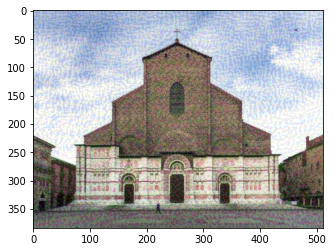

 10%|█         | 200/2000 [00:21<03:07,  9.58it/s]	Loss at step 200:	[23283050.]	[ S: 8582010.00; C: 11753202.00 ]


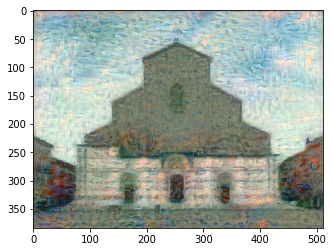

 20%|██        | 400/2000 [00:42<02:47,  9.55it/s]	Loss at step 400:	[19643320.]	[ S: 6553970.00; C: 10465557.00 ]


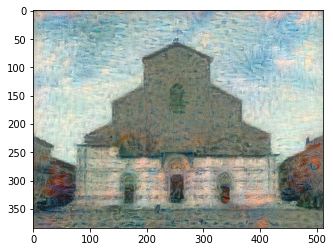

 30%|███       | 600/2000 [01:03<02:25,  9.61it/s]	Loss at step 600:	[17147684.]	[ S: 4810093.00; C: 9900288.00 ]


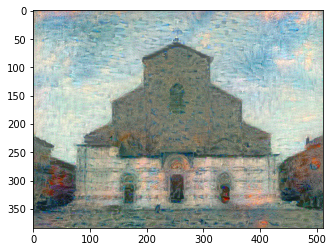

 40%|████      | 800/2000 [01:24<02:04,  9.62it/s]	Loss at step 800:	[15724693.]	[ S: 4136185.50; C: 9331888.00 ]


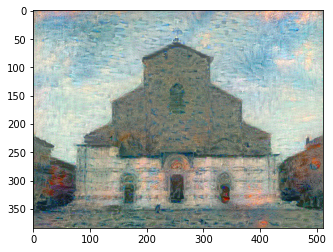

 50%|█████     | 1000/2000 [01:45<01:44,  9.59it/s]	Loss at step 1000:	[15420941.]	[ S: 3989564.75; C: 9233354.00 ]


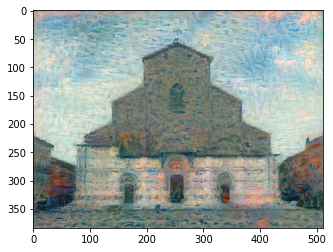

====================new weights: (40, 0.9), lr halved====================
 60%|██████    | 1200/2000 [02:06<01:24,  9.51it/s]	Loss at step 1200:	[15031027.]	[ S: 3931360.00; C: 9014522.00 ]


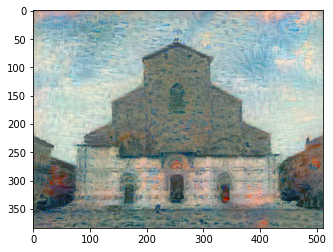

 70%|███████   | 1400/2000 [02:27<01:02,  9.55it/s]	Loss at step 1400:	[14502808.]	[ S: 3670292.50; C: 8831708.00 ]


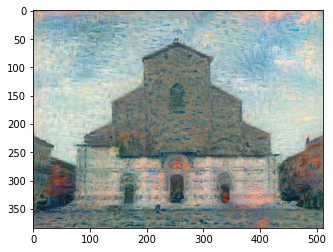

 80%|████████  | 1600/2000 [02:48<00:41,  9.58it/s]	Loss at step 1600:	[14552437.]	[ S: 3829660.00; C: 8777438.00 ]


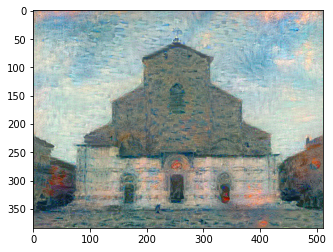

 90%|█████████ | 1800/2000 [03:09<00:20,  9.64it/s]	Loss at step 1800:	[14314922.]	[ S: 3682381.50; C: 8724228.00 ]


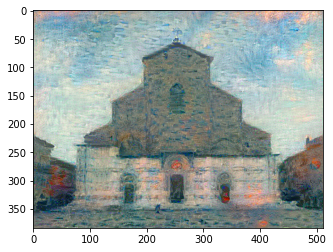

100%|██████████| 2000/2000 [03:30<00:00,  9.51it/s]
												Loss at step 2000:	[14082819.]	[ S: 3551794.00; C: 8660538.00 ]


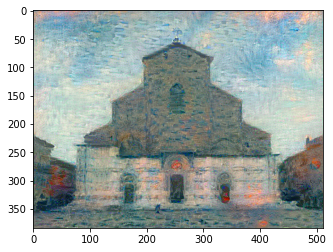

In [33]:
features_visualization = False

style_name = "rising_sun_impression.jpg"
content_name = "san_petronio.jpg"

steps = 2000
print_step = 200

W = (40, 0.8) # content weight, style weight

style_path = imgs_folder + "/style/" + style_name
content_path = imgs_folder + "/content/" + content_name
style_layers = ["block1_conv1", "block2_conv1", "block3_conv1", "block4_conv1", "block5_conv1"]
content_layers = ["block4_conv2"]

logger = Logger(log_folder, W[0], W[1], total_variation_weight, steps, content_name, style_name)

content_image = load_img(content_path)  # tf.Tensor, shape (1, x', y', 3), values in [0, 1]
style_image = load_img(style_path)      # the longest dimension x' or y' is equal to 512

"""It is possible to start the generation from a random noise image rather than
   from the content image by uncommenting these two lines and commenting the next one"""
# white_noise = np.random.uniform(0, 1, content_image.shape)
# gen_image = tf.Variable(white_noise, dtype=tf.float32)
gen_image = tf.Variable(content_image, dtype=tf.float32)

# plt.imshow(np.array(gen_image[0]))
# plt.show()

extractor = StyleContentExtractor(style_layers, content_layers)
style_targets, _ = extractor(style_image)
_, content_targets = extractor(content_image)

if features_visualization:
    show_feature_maps(extractor.content_extractor.vgg, content_image)

opt = tf.keras.optimizers.Adam(learning_rate=0.05)
print()

loss, s_loss, c_loss = 0, 0, 0
save_as = imgs_folder + "/generated/transfer/from_content/" + style_name.split(".")[0] + "_"
save_as += content_name.split(".")[0] + "_" + str(steps) + "_steps.jpg"

half = { 500: (40, 0.8), 1000: (40, 0.9), 1500: (40, 1.0), 2000: (40, 1.2) }

for _ in tqdm(range(steps), file=sys.stdout):
    if _ == 1 or _ != 0 and _ % print_step == 0:
        print("\tLoss at step {}:\t{}\t[ S: {:.2f}; C: {:.2f} ]".format(_, loss, s_loss, c_loss))
        logger.print_loss(_, loss[0], s_loss, c_loss)
        plt.imshow(np.array(gen_image[0]))
        plt.show()
    if _ == 200:
        opt.learning_rate = 0.04
        logger.param_change(_, W[0], W[1], total_variation_weight, 0.04)
    if _ in half.keys() :
        opt.learning_rate.assign(opt.learning_rate/2)
        W = half[_]
        print("="*20 + "new weights: " + str(half[_]) + ", lr halved" + "="*20)
        logger.param_change(_, W[0], W[1], total_variation_weight, opt.learning_rate.numpy())
    loss, s_loss, c_loss = update_image_step(gen_image, style_targets, content_targets, opt, extractor, W)

print("\t"*12 + "Loss at step {}:\t{}\t[ S: {:.2f}; C: {:.2f} ]".format(steps, loss, s_loss, c_loss))
logger.print_loss(_+1, loss[0], s_loss, c_loss)
logger.close()
plt.imshow(np.array(gen_image[0]))
plt.show()

array = np.array((gen_image[0] * 255), dtype=np.uint8)
Image.fromarray(array).save(save_as)
